In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install stow

In [ ]:
pip install tqdm

In [ ]:
pip install utils

In [ ]:
pip install mltu

In [ ]:
pip install tf2onnx

In [ ]:
import stow
import tarfile
from tqdm import tqdm
from urllib.request import urlopen
from io import BytesIO
from zipfile import ZipFile

In [ ]:
import tensorflow as tf
try: [tf.config.experimental.set_memory_growth(gpu, True) for gpu in tf.config.experimental.list_physical_devices("GPU")]
except: pass

from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard

from mltu.preprocessors import ImageReader
from mltu.transformers import ImageResizer, LabelIndexer, LabelPadding, ImageShowCV2
from mltu.augmentors import RandomBrightness, RandomRotate, RandomErodeDilate, RandomSharpen
from mltu.annotations.images import CVImage

from mltu.tensorflow.dataProvider import DataProvider
from mltu.tensorflow.losses import CTCloss
from mltu.tensorflow.callbacks import Model2onnx, TrainLogger
from mltu.tensorflow.metrics import CWERMetric

import os
import tarfile
from tqdm import tqdm
from urllib.request import urlopen
from io import BytesIO
from zipfile import ZipFile

In [ ]:
dataset, vocab, max_len = [], set(), 0
dataset_path="/content/drive/MyDrive/IAM_label/"

words = open(stow.join(dataset_path, "words.txt"), "r").readlines()
for line in tqdm(words):  # Iterate over tqdm as td
    if line.startswith("#"):
        continue

    line_split = line.split(" ")
    if line_split[1] == "err":
        continue

    folder1 = line_split[0][:3]
    line_split2=line.split("-")
    folder2 = line_split2[0]+ "-" +line_split2[1]
    file_name = line_split[0] + ".png"
    label = line_split[-1].rstrip('\n')

    rel_path = stow.join(dataset_path, "words", folder1, folder2, file_name)
    # if not stow.exists(rel_path):
    #     continue

    dataset.append([rel_path, label])
    vocab.update(list(label))
    max_len = max(max_len, len(label))

In [ ]:
import os
from datetime import datetime

from mltu.configs import BaseModelConfigs

class ModelConfigs(BaseModelConfigs):
    def __init__(self):
        super().__init__()
        self.model_path = os.path.join("/content/drive/MyDrive/03_handwriting_recognition", datetime.strftime(datetime.now(), "%Y%m%d%H%M"))
        self.vocab = ""
        self.height = 32
        self.width = 128
        self.max_text_length = 0
        self.batch_size = 16
        self.learning_rate = 0.0005
        self.train_epochs = 1000
        self.train_workers = 20

In [ ]:
# Create a ModelConfigs object to store model configurations
configs = ModelConfigs()

# Save vocab and maximum text length to configs
configs.vocab = "".join(vocab)
configs.max_text_length = max_len
configs.save()

In [ ]:
from mltu.tensorflow.dataProvider import DataProvider
from mltu.preprocessors import ImageReader
from mltu.transformers import ImageResizer, LabelIndexer, LabelPadding, ImageShowCV2
from mltu.augmentors import RandomBrightness, RandomRotate, RandomErodeDilate, RandomSharpen
from mltu.annotations.images import CVImage


In [ ]:
# Create a data provider for the dataset
data_provider = DataProvider(
    dataset=dataset,
    skip_validation=True,
    batch_size=configs.batch_size,
    data_preprocessors=[ImageReader(CVImage)],
    transformers=[
        ImageResizer(configs.width, configs.height, keep_aspect_ratio=False),
        LabelIndexer(configs.vocab),
        LabelPadding(max_word_length=configs.max_text_length, padding_value=len(configs.vocab))
        ],
)

# Split the dataset into training and validation sets
train_data_provider, val_data_provider = data_provider.split(split = 0.9)

# Augment training data with random brightness, rotation and erode/dilate
train_data_provider.augmentors = [RandomBrightness(), RandomRotate(), RandomErodeDilate()]

INFO:DataProvider:Skipping Dataset validation...


In [ ]:
from keras import layers
from keras.models import Model

def train_model(input_dim, output_dim, activation='leaky_relu', dropout=0.2):

    inputs = layers.Input(shape=input_dim, name="input")

    # normalize images here instead in preprocessing step
    input_normalized = layers.Lambda(lambda x: x / 255)(inputs)

    # Convolutional Layers
    x = layers.Conv2D(16, (3, 3), activation=activation, padding='same')(input_normalized)
    x = layers.MaxPooling2D((2, 2), strides=(1, 1), padding='same')(x)

    x = layers.Conv2D(16, (3, 3), activation=activation, padding='same')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same')(x)

    x = layers.Conv2D(16, (3, 3), activation=activation, padding='same')(x)
    x = layers.MaxPooling2D((2, 2), strides=(1, 1), padding='same')(x)

    x = layers.Conv2D(32, (3, 3), activation=activation, padding='same')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same')(x)

    x = layers.Conv2D(32, (3, 3), activation=activation, padding='same')(x)
    x = layers.MaxPooling2D((2, 2), strides=(1, 1), padding='same')(x)

    x = layers.Conv2D(64, (3, 3), activation=activation, padding='same')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same')(x)

    x = layers.Conv2D(64, (3, 3), activation=activation, padding='same')(x)
    x = layers.MaxPooling2D((2, 2), strides=(1, 1), padding='same')(x)

    x = layers.Conv2D(64, (3, 3), activation=activation, padding='same')(x)
    x = layers.MaxPooling2D((2, 2), strides=(1, 1), padding='same')(x)

    # Reshape and BLSTM
    squeezed = layers.Reshape((-1, 64))(x)  # Reshape to fit BLSTM input
    blstm = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(squeezed)
    blstm = layers.Dropout(dropout)(blstm)

    output = layers.Dense(output_dim + 1, activation='softmax', name="output")(blstm)

    model = Model(inputs=inputs, outputs=output)
    return model


In [ ]:
import tensorflow as tf
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
# from utils.train_logger_module import TrainLogger
# from onnx import Model2onnx

# Define callbacks
earlystopper = EarlyStopping(monitor='val_CER', patience=20, verbose=1)
checkpoint = ModelCheckpoint(f"{configs.model_path}/model.h5", monitor='val_CER', verbose=1, save_best_only=True, mode='min')
# trainLogger = TrainLogger(configs.model_path)
tb_callback = TensorBoard(f'{configs.model_path}/logs', update_freq=1)
reduceLROnPlat = ReduceLROnPlateau(monitor='val_CER', factor=0.9, min_delta=1e-10, patience=10, verbose=1, mode='auto')
# model2onnx = Model2onnx(f"{configs.model_path}/model.h5")

In [ ]:
import tensorflow as tf
# Creating TensorFlow model architecture
model = train_model(
    input_dim = (configs.height, configs.width, 3),
    output_dim = len(configs.vocab),
)

# Compile the model and print summary
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=configs.learning_rate),
    loss=CTCloss(),
    metrics=[CWERMetric(padding_token=len(configs.vocab))],
    run_eagerly=False
)
model.summary(line_length=110)


Model: "model"
______________________________________________________________________________________________________________
 Layer (type)                                    Output Shape                                Param #          
 input (InputLayer)                              [(None, 96, 1408, 3)]                       0                
                                                                                                              
 lambda (Lambda)                                 (None, 96, 1408, 3)                         0                
                                                                                                              
 conv2d (Conv2D)                                 (None, 96, 1408, 16)                        448              
                                                                                                              
 max_pooling2d (MaxPooling2D)                    (None, 96, 1408, 16)                        0   

In [ ]:
from keras import layers
from keras.models import Model

def residual_block(input_tensor, num_filters, activation='relu', kernel_size=(3, 3), strides=1, dropout=0.0, skip_conv=True):
    # Main path
    x = layers.Conv2D(num_filters, kernel_size, strides=strides, padding='same')(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(activation)(x)
    x = layers.Dropout(dropout)(x)

    x = layers.Conv2D(num_filters, kernel_size, padding='same')(x)
    x = layers.BatchNormalization()(x)

    # Skip connection
    if skip_conv:
        skip = layers.Conv2D(num_filters, (1, 1), strides=strides, padding='same')(input_tensor)
        x = layers.add([x, skip])
    else:
        x = layers.add([x, input_tensor])

    x = layers.Activation(activation)(x)
    return x

def train_model(input_dim, output_dim, activation='leaky_relu', dropout=0.2):
    inputs = layers.Input(shape=input_dim, name="input")

    # normalize images here instead in preprocessing step
    input = layers.Lambda(lambda x: x / 255)(inputs)

    x1 = residual_block(input, 16, activation=activation, skip_conv=True, strides=1, dropout=dropout)

    x2 = residual_block(x1, 16, activation=activation, skip_conv=True, strides=2, dropout=dropout)
    x3 = residual_block(x2, 16, activation=activation, skip_conv=False, strides=1, dropout=dropout)

    x4 = residual_block(x3, 32, activation=activation, skip_conv=True, strides=2, dropout=dropout)
    x5 = residual_block(x4, 32, activation=activation, skip_conv=False, strides=1, dropout=dropout)

    x6 = residual_block(x5, 64, activation=activation, skip_conv=True, strides=2, dropout=dropout)
    x7 = residual_block(x6, 64, activation=activation, skip_conv=True, strides=1, dropout=dropout)

    x8 = residual_block(x7, 64, activation=activation, skip_conv=False, strides=1, dropout=dropout)
    x9 = residual_block(x8, 64, activation=activation, skip_conv=False, strides=1, dropout=dropout)

    squeezed = layers.Reshape((x9.shape[-3] * x9.shape[-2], x9.shape[-1]))(x9)

    blstm = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(squeezed)
    blstm = layers.Dropout(dropout)(blstm)

    output = layers.Dense(output_dim + 1, activation='softmax', name="output")(blstm)

    model = Model(inputs=inputs, outputs=output)
    return model


In [ ]:
# Define callbacks
earlystopper = EarlyStopping(monitor='val_CER', patience=20, verbose=1)
checkpoint = ModelCheckpoint(f"{configs.model_path}/model.h5", monitor='val_CER', verbose=1, save_best_only=True, mode='min')
trainLogger = TrainLogger(configs.model_path)
tb_callback = TensorBoard(f'{configs.model_path}/logs', update_freq=1)
reduceLROnPlat = ReduceLROnPlateau(monitor='val_CER', factor=0.9, min_delta=1e-10, patience=10, verbose=1, mode='auto')
model2onnx = Model2onnx(f"{configs.model_path}/model.h5")

In [ ]:
# Train the model
model.fit(
    train_data_provider,
    validation_data=val_data_provider,
    epochs=configs.train_epochs,
    callbacks=[earlystopper, checkpoint, trainLogger, reduceLROnPlat, tb_callback, model2onnx],
    workers=configs.train_workers
)


In [ ]:
train_data_provider.to_csv(stow.join("/content/drive/MyDrive/Models/03_handwriting_recognition", 'train.csv'))
val_data_provider.to_csv(stow.join("/content/drive/MyDrive/Models/03_handwriting_recognition", 'val.csv'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/lambda_layer.py:327: UserWarning: model is not loaded, but a Lambda layer uses it. It may cause errors.
  function = cls._parse_function_from_config(


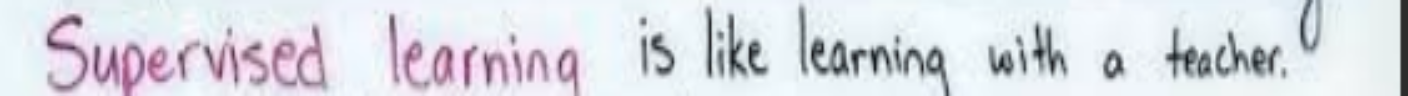

1/1 [==============================] - 3s 3s/step
Prediction:  Surieed tearina is like leaming with a tecter! 
Label: Supervised learing is like leaning with a techer!
CER: 0.20408163265306123; WER: 0.5


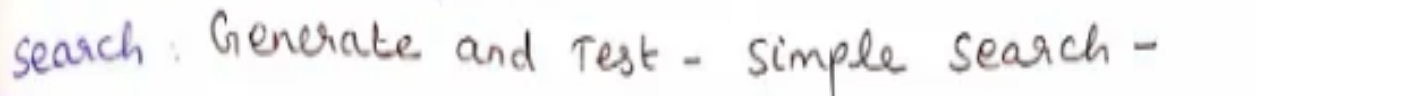

1/1 [==============================] - 1s 569ms/step
Prediction: search , Generake and rest - simple seach- 
Label: search : Generate and test - simple search-
CER: 0.11627906976744186; WER: 0.5


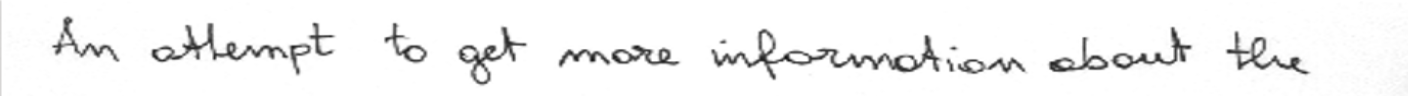

1/1 [==============================] - 1s 795ms/step
Prediction:  In attermpt to get mone infounation bout tehe 
Label: An attempt to get more information about the
CER: 0.20454545454545456; WER: 0.75


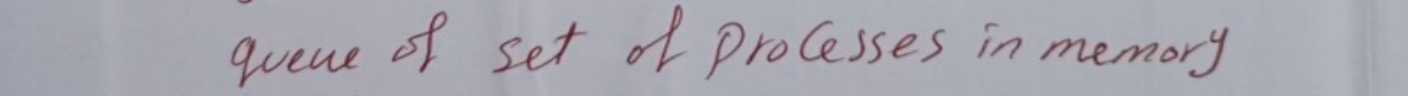

1/1 [==============================] - 1s 1s/step
Prediction:  quene of set t prolesses inmemory 
Label: queue of set of processes in memory
CER: 0.2; WER: 0.7142857142857143


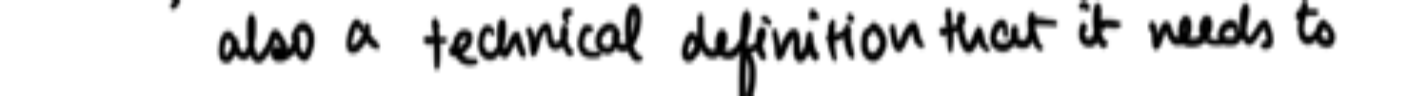

1/1 [==============================] - 1s 1s/step
Prediction:  als a tecunteal definitton that it reeds to 
Label:  also a technical definition that it needs to 
CER: 0.13043478260869565; WER: 0.5


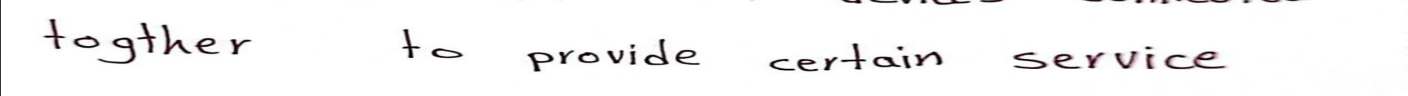

1/1 [==============================] - 1s 1s/step
Prediction: l tosther t- prouide ccrtain service 
Label:  togther to provide certain service
CER: 0.17142857142857143; WER: 1.0


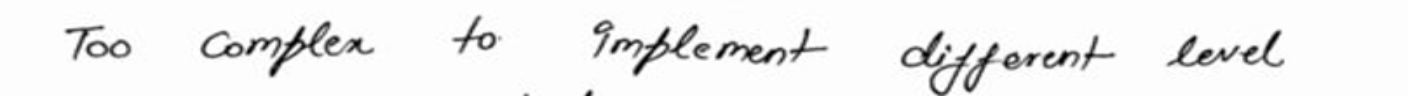

1/1 [==============================] - 1s 579ms/step
Prediction:  To complen to amplement dyyorent evel 
Label:  Too complex to implement diffrent level
CER: 0.2; WER: 0.8333333333333334


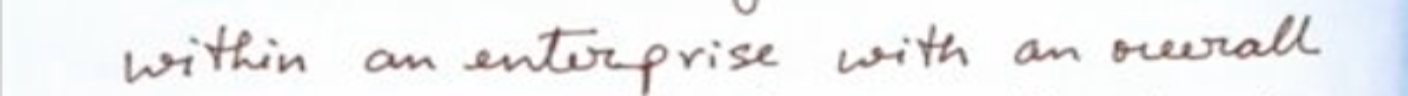

1/1 [==============================] - 1s 556ms/step
Prediction:  within an entouprise with an ourall 
Label: within an enterprise with an overall
CER: 0.16666666666666666; WER: 0.3333333333333333


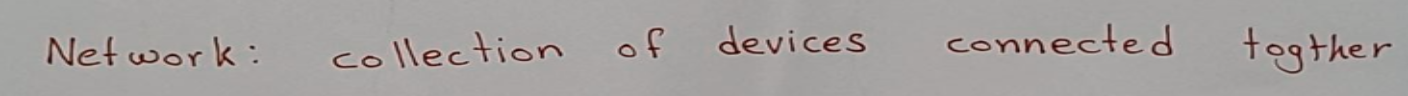

1/1 [==============================] - 1s 590ms/step
Prediction: " wetwork- collection of devices commected tosther 
Label: Network : collection of devices connected togther
CER: 0.1836734693877551; WER: 0.5714285714285714


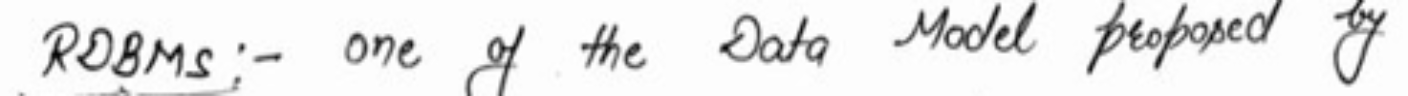

1/1 [==============================] - 1s 589ms/step
Prediction:  poous :- one of the Data Nodel peopored &
Label: RDBMS :- one of the Data Model peoposed by
CER: 0.23809523809523808; WER: 0.4444444444444444


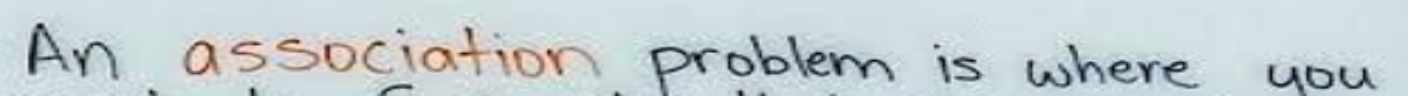

1/1 [==============================] - 1s 571ms/step
Prediction: An associotion probtem is where won
Label: An associotion problem is where you
CER: 0.08571428571428572; WER: 0.3333333333333333


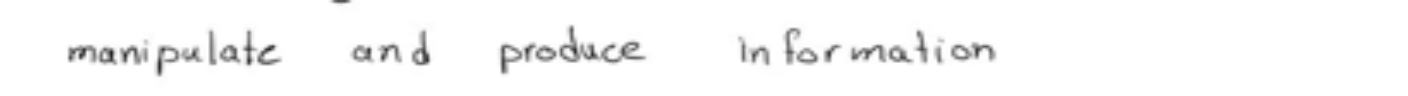

1/1 [==============================] - 1s 567ms/step
Prediction:  mampulate and prodce information 
Label: manipulate and produce information
CER: 0.14705882352941177; WER: 0.5


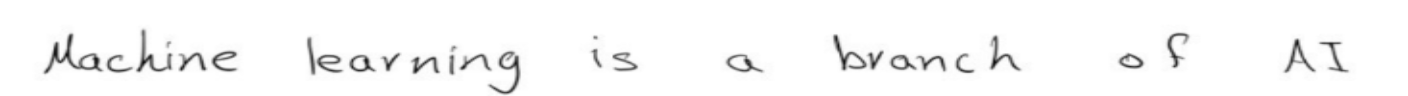

1/1 [==============================] - 1s 586ms/step
Prediction:  Hachine learning is a branch oo a 
Label: Machine learning is a branch of AI
CER: 0.14705882352941177; WER: 0.42857142857142855


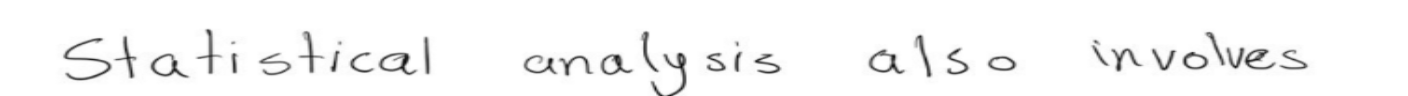

1/1 [==============================] - 1s 542ms/step
Prediction:  statistical analysis also mnvoives 
Label:  statistical analysis also invoives
CER: 0.05714285714285714; WER: 0.25


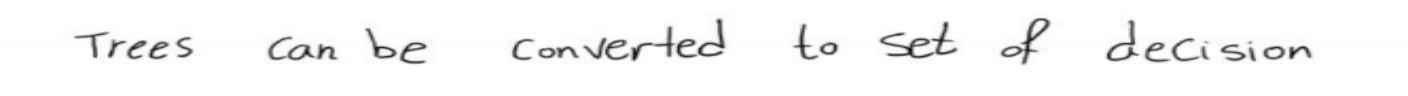

1/1 [==============================] - 1s 565ms/step
Prediction:  Trees can be converted to set of decsion 
Label: Trees can be converted to set of decsion
CER: 0.05; WER: 0.0


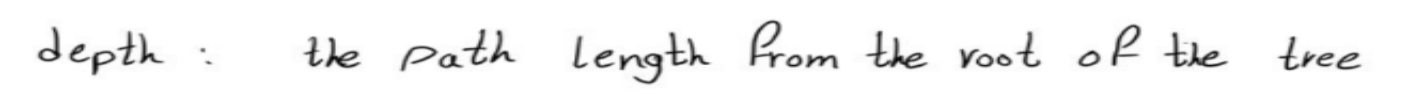

1/1 [==============================] - 1s 593ms/step
Prediction:  depth : Ie path Length From the rost of the tree 
Label: depth : the path length from the root of the tree
CER: 0.14285714285714285; WER: 0.36363636363636365


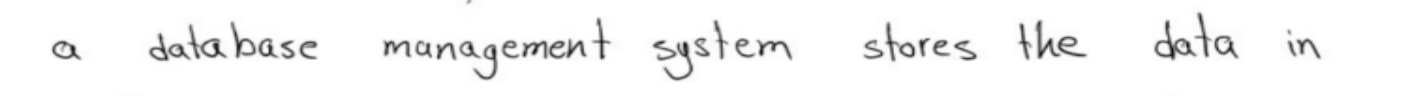

1/1 [==============================] - 1s 567ms/step
Prediction:  a satabase management system stores the data in 
Label:  a database management system stores the data in
CER: 0.041666666666666664; WER: 0.125


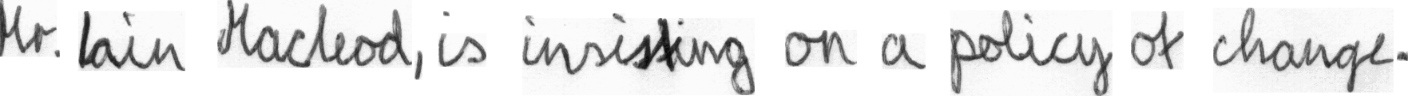

1/1 [==============================] - 1s 566ms/step
Prediction: Mr. Iain Macleod , is insisting on a policy ot change .
Label: Mr. Iain Macleod , is insisting on a policy of change .
CER: 0.01818181818181818; WER: 0.08333333333333333
Average CER: 0.13916029459858212, Average WER: 0.4572611030944364


In [ ]:
from keras.models import load_model
import numpy as np
from mltu.utils.text_utils import ctc_decoder, get_cer, get_wer
from google.colab.patches import cv2_imshow
import cv2
from mltu.configs import BaseModelConfigs
import pandas as pd

configs = BaseModelConfigs.load("/content/drive/MyDrive/202301131202/configs.yaml")
model = load_model('/content/drive/MyDrive/202301131202/model.h5', custom_objects={'CTCloss': CTCloss}, compile=False)
df=pd.read_excel("/content/Book1.xlsx")
avg_cer, avg_wer=[],[]

for idx,i in enumerate(df["Label"]):
    path=df["Image path"][idx]
    image_path="/content/drive/MyDrive/test images/"+path
    img = cv2.imread(image_path)
    image = cv2.resize(img, (1408, 96))
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = np.expand_dims(gray, axis=0)
    cv2_imshow(gray)

    prediction_text = model.predict(image)[0]
    prediction_text = np.array([prediction_text])
    text = ctc_decoder(prediction_text,configs.vocab)
    label=i
    print("Prediction:", text[0])
    cer = get_cer(text[0], label)
    print("Label:", label)
    wer = get_wer(text[0], label)
    avg_cer.append(cer)
    avg_wer.append(wer)
    print(f"CER: {cer}; WER: {wer}")


print(f"Average CER: {np.average(avg_cer)}, Average WER: {np.average(avg_wer)}")